In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import json
plt.rcParams["figure.figsize"] = (20,10)

# Chargement des prix au format .json

In [173]:
def prices_goat(card):
    r = requests.get("https://www.goatbots.com/card/ajax_card?search_name=" + card)
    all_prices = r.json()[1] # r.json()[0] est un header qui ne nous intéresse pas
    prices = all_prices[0] # prix d'une édition de card
    d = pd.DataFrame(prices, columns = ["Date", "Sell Price"])
    d['Date'] = pd.to_datetime(d['Date'])
    d = d.set_index('Date')
    return d

In [278]:
prices = prices_goat("treasure-chest-booster")

<AxesSubplot:xlabel='Date'>

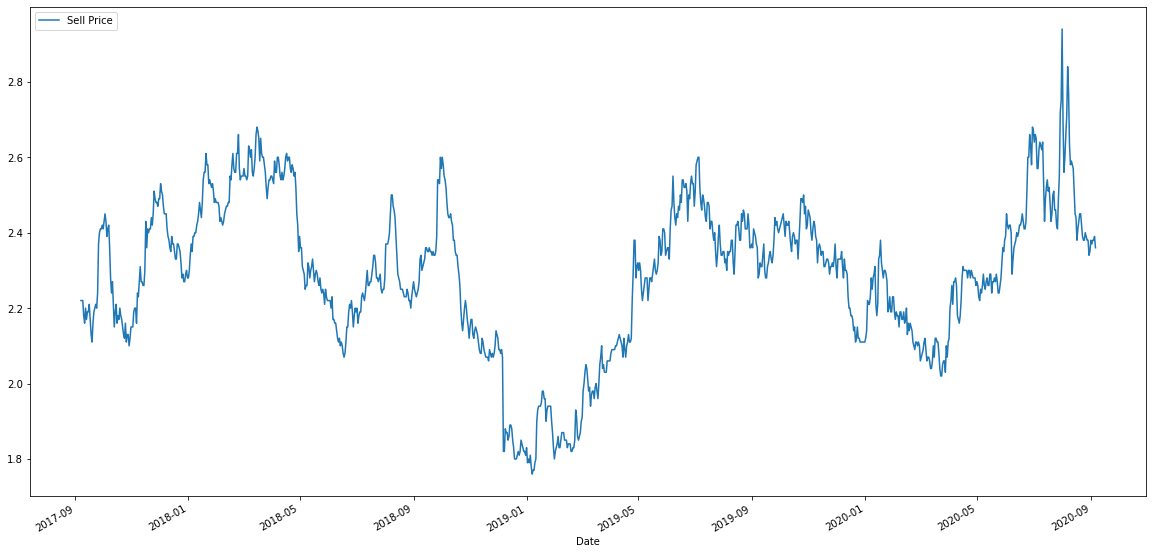

In [279]:
prices.plot()

<AxesSubplot:xlabel='Date'>

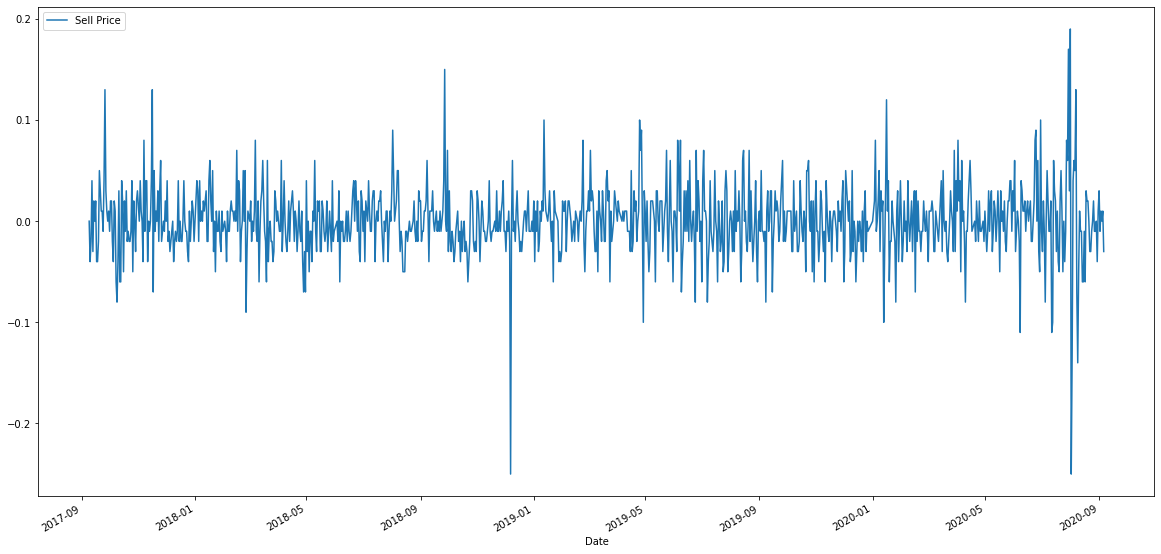

In [333]:
prices.diff(periods=1).plot()

In [336]:
prices["Sell Price"].diff(10)[10:]

Date
2017-09-18   -0.09
2017-09-19   -0.11
2017-09-20   -0.02
2017-09-21    0.03
2017-09-22    0.00
              ... 
2020-09-02   -0.02
2020-09-03    0.00
2020-09-04    0.00
2020-09-05   -0.01
2020-09-06   -0.03
Name: Sell Price, Length: 1052, dtype: float64

In [339]:
prices["Sell Price"][12] - prices["Sell Price"][2]

-0.020000000000000018

0.026072910829412613

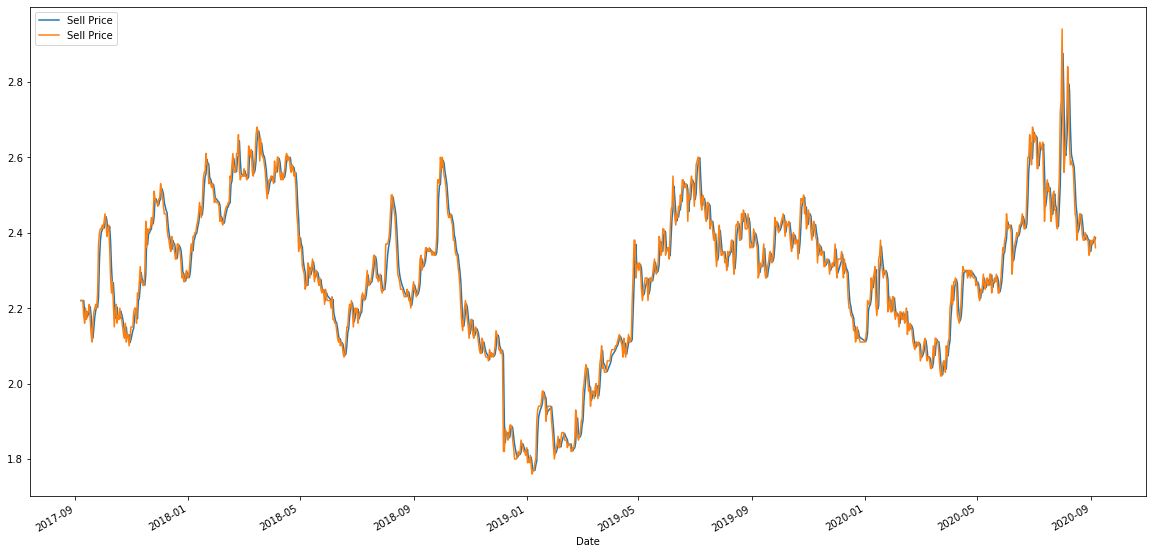

In [288]:
def exp_mov_avg(d, a):
    ema = d.copy()
    for i in range(1, len(d)):
        ema.iloc[i] = a * d.iloc[i - 1] + (1 - a) * ema.iloc[i - 1]
    return ema
ema = exp_mov_avg(prices, 0.7)
axe = ema.plot()
prices.plot(ax=axe)
(prices["Sell Price"] - ema["Sell Price"]).abs().mean()

0.10463656699705245

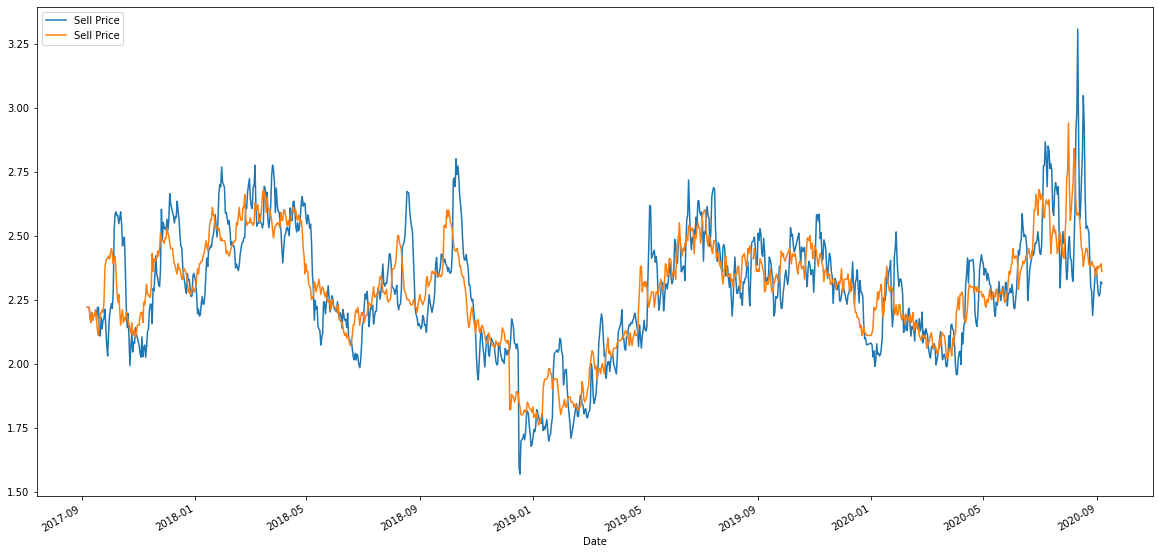

In [329]:
def holt(d, a, b):
    pred_next = d.copy()
    pred = d.copy()
    trend = d.copy()
    trend.iloc[0] = d.iloc[1] - d.iloc[0]
    for i in range(1, len(d)):
        if i >= 10:
            pred_next.iloc[i] = pred.iloc[i-10] + 10*trend.iloc[i-10]
        pred.iloc[i] = a*d.iloc[i] + (1 - a)*(pred.iloc[i-1] + trend.iloc[i - 1])
        trend.iloc[i] = b*(pred.iloc[i] - pred.iloc[i - 1]) + (1 - b)*trend.iloc[i - 1]
    return pred_next, pred, trend
p, pred, trend = holt(prices, 0.9, 0.1)
axe = p.plot()
prices.plot(ax=axe)
(prices["Sell Price"] - p["Sell Price"]).abs().mean()

# Prophet

In [290]:
from fbprophet import Prophet
m = Prophet(daily_seasonality=True)
d = pd.DataFrame({"ds": prices.index, "y": prices["Sell Price"]})
m.fit(d)

In [291]:
future = m.make_future_dataframe(periods=365, freq="D")
future.tail()

,ds
1422,2021-09-02
1423,2021-09-03
1424,2021-09-04
1425,2021-09-05
1426,2021-09-06


In [292]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1422,2021-09-02,2.523181,0.733835,4.130369
1423,2021-09-03,2.522143,0.727538,4.139452
1424,2021-09-04,2.530528,0.769996,4.186084
1425,2021-09-05,2.514675,0.717406,4.159783
1426,2021-09-06,2.500785,0.707888,4.136751


In [330]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial="500 days", horizon="10 days", period="60 days", )

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-03-06 00:00:00 and 2020-08-27 00:00:00


In [331]:
df_cv.head()
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,0.007732,0.087931,0.083264,0.036364,0.030069,0.400000
1,2 days,0.009633,0.098147,0.092752,0.039581,0.038712,0.300000
2,3 days,0.010804,0.103940,0.091986,0.039118,0.040292,0.400000
3,4 days,0.010547,0.102701,0.084710,0.036402,0.036140,0.300000
4,5 days,0.011980,0.109454,0.082012,0.034702,0.025156,0.666667
5,6 days,0.011348,0.106528,0.083963,0.035943,0.036764,0.300000
6,7 days,0.012726,0.112808,0.080152,0.034944,0.028265,0.600000
7,8 days,0.017128,0.130875,0.103320,0.044978,0.039769,0.400000
8,9 days,0.021936,0.148109,0.109866,0.047320,0.042819,0.400000
9,10 days,0.024812,0.157518,0.120144,0.052047,0.051625,0.200000


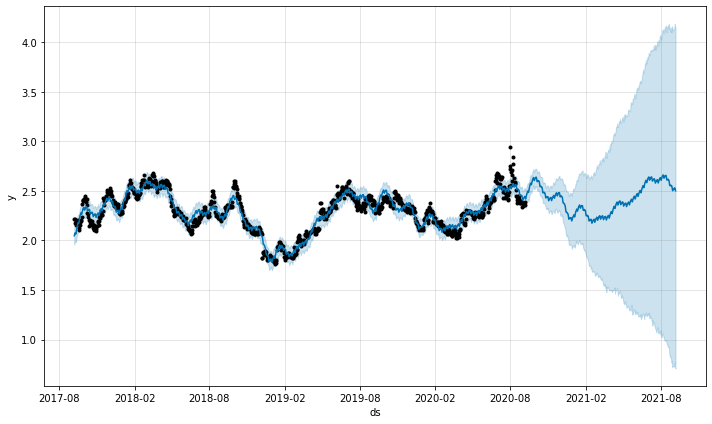

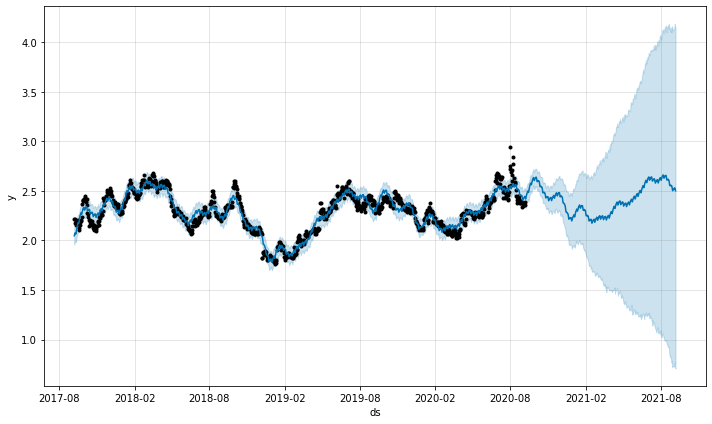

In [332]:
m.plot(forecast)

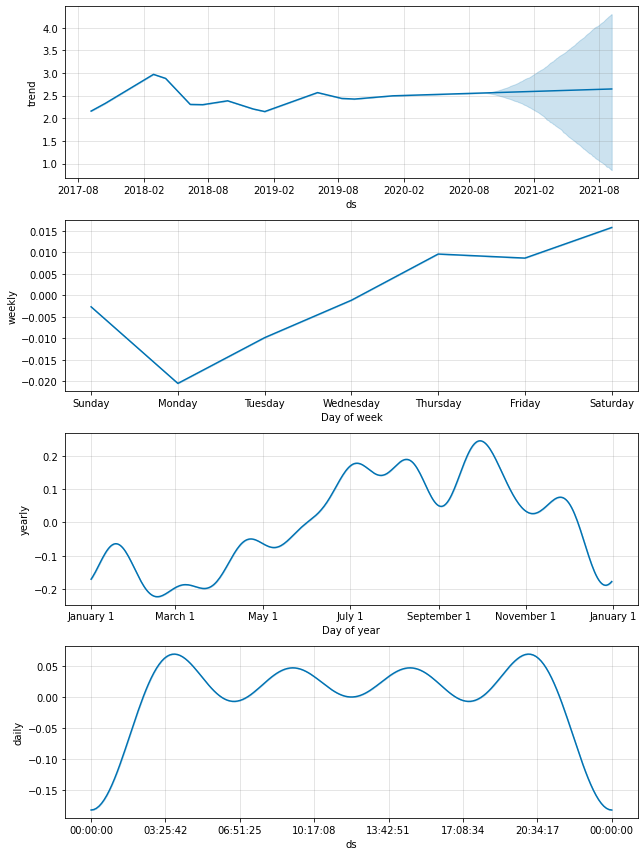

In [299]:
fig2 = m.plot_components(forecast)